# Unsupervised Learning on Blood Biomarker Data
This notebook applies unsupervised machine learning to blood biomarker data to identify patient subgroups (potential PD subtypes) based solely on their blood profiles over time.

## 1. Load Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 2. Load and Inspect Blood Data
Choose the most comprehensive blood biomarker file for clustering.

In [13]:
# Load blood biomarker data
blood_df = pd.read_csv('../../data/blood/BLOOD_DATE_FORMATTED_CSF_FILTERED.csv')
blood_df.head()

,PATNO,SEX,COHORT,CLINICAL_EVENT,TYPE,TESTNAME,TESTVALUE,UNITS,RUNDATE,PROJECTID,PI_NAME,PI_INSTITUTION,update_stamp
0,3000,Female,Control,V04,Cerebrospinal Fluid,ABeta 1-42,1060,pg/mL,2017-06-27,125,Les Shaw,University of Pennsylvania,2017-10-20 09:04:05.0
1,3000,Female,Control,BL,Cerebrospinal Fluid,CSF Alpha-synuclein,1798.9,pg/ml,2016-10-11,124,Peggy Taylor,Biolegend,2017-04-03 08:50:27.0
2,3000,Female,Control,V08,Cerebrospinal Fluid,pTau,21.15,pg/mL,2017-06-27,125,Les Shaw,University of Pennsylvania,2017-10-20 09:04:05.0
3,3000,Female,Control,V08,Cerebrospinal Fluid,ABeta 1-42,820.5,pg/mL,2017-06-27,125,Les Shaw,University of Pennsylvania,2017-10-20 09:04:05.0
4,3000,Female,Control,V04,Cerebrospinal Fluid,CSF Alpha-synuclein,1547.0,pg/ml,2016-10-11,124,Peggy Taylor,Biolegend,2017-04-03 08:50:27.0


## 3. Data Preprocessing
- Handle missing values
- Select relevant biomarker columns
- Aggregate or pivot data if needed (e.g., mean per patient or per timepoint)

In [14]:
to_drop = ['CLINICAL_EVENT','RUNDATE','TYPE','UNITS']
# identify candidate biomarker columns
biomarker_cols = [c for c in blood_df.columns if c not in ['PATNO'] + to_drop]

# convert all biomarker columns to numeric, coercing non‑numeric to NaN
for c in biomarker_cols:
    blood_df[c] = pd.to_numeric(blood_df[c], errors='coerce')

# keep only PATNO + numeric biomarker features
df_num = blood_df[['PATNO'] + biomarker_cols].select_dtypes(include='number')

# aggregate per patient (mean)
biomarker_df = df_num.groupby('PATNO').mean()

# impute any remaining NaNs with feature medians 
biomarker_df = biomarker_df.fillna(biomarker_df.median())

biomarker_df.head()

,SEX,COHORT,TESTNAME,TESTVALUE,PROJECTID,PI_NAME,PI_INSTITUTION,update_stamp
PATNO,,,,,,,,
3000,NaN,NaN,NaN,709.835833,128.416667,NaN,NaN,NaN
3001,NaN,NaN,NaN,258.527455,144.000000,NaN,NaN,NaN
3002,NaN,NaN,NaN,313.701478,144.217391,NaN,NaN,NaN
3003,NaN,NaN,NaN,201.180119,141.357143,NaN,NaN,NaN
3004,NaN,NaN,NaN,210.162125,143.050000,NaN,NaN,NaN


## 4. Feature Scaling
Standardize biomarker values for clustering.

In [17]:
from sklearn.impute import SimpleImputer

# If any NaNs remain in biomarker_df, fill with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(biomarker_df)

# Now scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SEX' 'COHORT' 'TESTNAME' 'PI_NAME' 'PI_INSTITUTION' 'update_stamp']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


## 5. Dimensionality Reduction (PCA for Visualization)

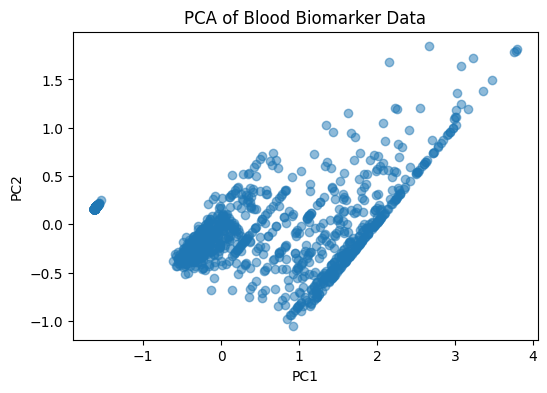

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title('PCA of Blood Biomarker Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 6. Clustering (KMeans Example)
Try different cluster numbers and use silhouette score to select the best.

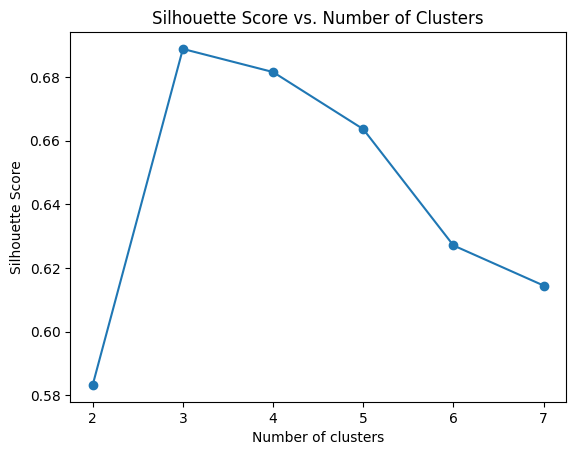

In [19]:
scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)
plt.plot(range(2,8), scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

## 7. Assign Cluster Labels and Visualize
Choose optimal k and visualize clusters in PCA space.

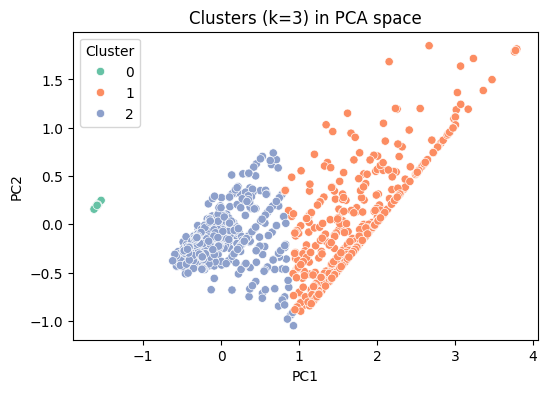

In [20]:
optimal_k = np.argmax(scores) + 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)
biomarker_df['cluster'] = labels
plt.figure(figsize=(6,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='Set2')
plt.title(f'Clusters (k={optimal_k}) in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

## 8. Cluster Profiling
Examine mean biomarker values per cluster to interpret biological differences.

In [21]:
cluster_profiles = biomarker_df.groupby('cluster').mean()
cluster_profiles

,SEX,COHORT,TESTNAME,TESTVALUE,PROJECTID,PI_NAME,PI_INSTITUTION,update_stamp
cluster,,,,,,,,
0,NaN,NaN,NaN,15.062718,159.000000,NaN,NaN,NaN
1,NaN,NaN,NaN,773.307146,127.354035,NaN,NaN,NaN
2,NaN,NaN,NaN,321.244935,141.405424,NaN,NaN,NaN


## 9. Next Steps: Correlate Clusters with Motor Outcomes
- Merge cluster assignments with motor dataset (e.g., MDS-UPDRS scores) by patient ID.
- Investigate if clusters differ in clinical progression or symptom types.